In [4]:
!pip install sympy
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

Building jupyterlab assets (build:prod:minimize)
Building jupyterlab assets (build:prod:minimize)


[@LorenaABarba](https://twitter.com/LorenaABarba)

12 steps to Navier–Stokes
=====
***

The final two steps in this interactive module teaching beginning [CFD with Python](https://bitbucket.org/cfdpython/cfd-python-class) will both solve the Navier–Stokes equations in two dimensions, but with different boundary conditions.

The momentum equation in vector form for a velocity field $\vec{v}$ is:

$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$

This represents three scalar equations, one for each velocity component $(u,v,w)$. But we will solve it in two dimensions, so there will be two scalar equations.

Remember the continuity equation? This is where the [Poisson equation](./13_Step_10.ipynb) for pressure comes in!

Step 11: Cavity Flow with Navier–Stokes
----
***

Here is the system of differential equations: two equations for the velocity components $u,v$ and one equation for pressure:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

From the previous steps, we already know how to discretize all these terms. Only the last equation is a little unfamiliar. But with a little patience, it will not be hard!

### Discretized equations

First, let's discretize the $u$-momentum equation, as follows:

$$
\begin{split}
& \frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y} = \\ 
& \qquad -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x}+\nu\left(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2}\right)
\end{split}
$$

Similarly for the $v$-momentum equation:

$$
\begin{split}
&\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y} = \\
& \qquad -\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y}
+\nu\left(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2}\right)
\end{split}
$$

Finally, the discretized pressure-Poisson equation can be written thus:

$$
\begin{split}
& \frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2} = \\
& \qquad \rho \left[ \frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right) -\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} - 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} - \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

You should write these equations down on your own notes, by hand, following each term mentally as you write it.

As before, let's rearrange the equations in the way that the iterations need to proceed in the code. First, the momentum equations for the velocity at the next time step.


The momentum equation in the $u$ direction:

$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right)
\end{split}
$$

The momentum equation in the $v$ direction:

$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(v_{i,j}^{n}-v_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(v_{i,j}^{n}-v_{i,j-1}^{n})\right) \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right)
\end{split}
$$

Almost there! Now, we rearrange the pressure-Poisson equation:

$$
\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

The initial condition is $u, v, p = 0$ everywhere, and the boundary conditions are:

$u=1$ at $y=2$ (the "lid");

$u, v=0$ on the other boundaries;

$\frac{\partial p}{\partial y}=0$ at $y=0$;

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ at $x=0,2$


Implementing Cavity Flow
----


In [5]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [6]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

The pressure Poisson equation that's written above can be hard to write out without typos.  The function `build_up_b` below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.  

In [7]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

#     print("b", b)
    return b

The function `pressure_poisson` is also defined to help segregate the different rounds of calculations.  Note the presence of the pseudo-time variable `nit`.  This sub-iteration in the Poisson calculation helps ensure a divergence-free field.  

In [8]:
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (    (  (pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2  + 
                             (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) / (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

#         print("p before", p)
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
#         print("p1", p)
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
#         print("p2", p)
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
#         print("p3", p)
        p[-1, :] = 0        # p = 0 at y = 2
    
    print("p", p)
    return p

In [9]:
myList = [['a', 'b'], ['c', 'd']]
print(myList[:][-1]) # prints 'e'

['c', 'd']


Finally, the rest of the cavity flow equations are wrapped inside the function `cavity_flow`, allowing us to easily plot the results of the cavity flow solver for different lengths of time.  

In [10]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nit):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
#         print("1", un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) )
#         print("2", vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1])) 
#         print("3", dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) )
#         print("4", nu * (dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2])))
#         print("5", dt / dy**2 *(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

#         print("before", u)
        u[0, :]  = 0
#         print("after1" , u)
        u[:, 0]  = 0
#         print("after2" , u)
        u[:, -1] = 0
#         print("after3" , u)
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
#         print("after4" , u)
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
#         print(u)
    return u, v, p

Let's start with `nt = 100` and see what the solver gives us:

In [11]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

p [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
p [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
p [[-3.96453208e-17 -3.96453208e-17 -3.70012254e-17 ...  3.70308382e-17
   3.96770497e-17  3.96770497e-17]
 [-3.96453208e-17 -3.96453208e-17 -3.70012254e-17 ...  3.70308382e-17
   3.96770497e-17  3.96770497e-17]
 [-2.64032970e-16 -2.64032970e-16 -2.32952608e-16 ...  2.33139045e-16
   2.64244281e-16  2.64244281e-16]
 ...
 [-2.78220334e-01 -2.78220334e-01 -1.74012335e-01 ...  1.74151601e-01
   2.78443000e-01  2.78443000e-01]
 [-4.87441649e-01 -4.87441649e-01 -1.85455253e-01 ...  1.85603677e-01
   4.87831758e-01  4.87831758e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
p [[-9.88126160e-09 -9.88126160e-09 -9.6379115

p [[-0.04109492 -0.04109492 -0.04083974 ...  0.04316454  0.04341841
   0.04341841]
 [-0.04109492 -0.04109492 -0.04083974 ...  0.04316454  0.04341841
   0.04341841]
 [-0.04146664 -0.04146664 -0.04120358 ...  0.04353463  0.04379635
   0.04379635]
 ...
 [-1.14456738 -1.14456738 -0.81160433 ...  0.8133527   1.15777395
   1.15777395]
 [-2.66978979 -2.66978979 -1.58941178 ...  1.57411986  2.67283626
   2.67283626]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
p [[-0.03866986 -0.03866986 -0.03846273 ...  0.04123569  0.04144125
   0.04144125]
 [-0.03866986 -0.03866986 -0.03846273 ...  0.04123569  0.04144125
   0.04144125]
 [-0.03904225 -0.03904225 -0.03882847 ...  0.04160767  0.04181984
   0.04181984]
 ...
 [-1.15704778 -1.15704778 -0.82118111 ...  0.8235498   1.17158115
   1.17158115]
 [-2.69743114 -2.69743114 -1.61388937 ...  1.59834076  2.7012259
   2.7012259 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
p [[-0.03852263 -0.03852263 -

p [[-0.05586205 -0.05586205 -0.05574347 ...  0.06877786  0.06889437
   0.06889437]
 [-0.05586205 -0.05586205 -0.05574347 ...  0.06877786  0.06889437
   0.06889437]
 [-0.0559963  -0.0559963  -0.05587797 ...  0.06890727  0.06902389
   0.06902389]
 ...
 [-1.29879357 -1.29879357 -0.93078324 ...  0.94683322  1.33709856
   1.33709856]
 [-2.977615   -2.977615   -1.86862622 ...  1.85780255  2.99983267
   2.99983267]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
p [[-0.05461695 -0.05461695 -0.0545229  ...  0.06783229  0.06792451
   0.06792451]
 [-0.05461695 -0.05461695 -0.0545229  ...  0.06783229  0.06792451
   0.06792451]
 [-0.0547445  -0.0547445  -0.0546511  ...  0.06795515  0.06804709
   0.06804709]
 ...
 [-1.30273726 -1.30273726 -0.93369721 ...  0.95047193  1.34214328
   1.34214328]
 [-2.98475088 -2.98475088 -1.8751185  ...  1.86487881  3.00804543
   3.00804543]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
p [[-0.0539838  -0.0539838  

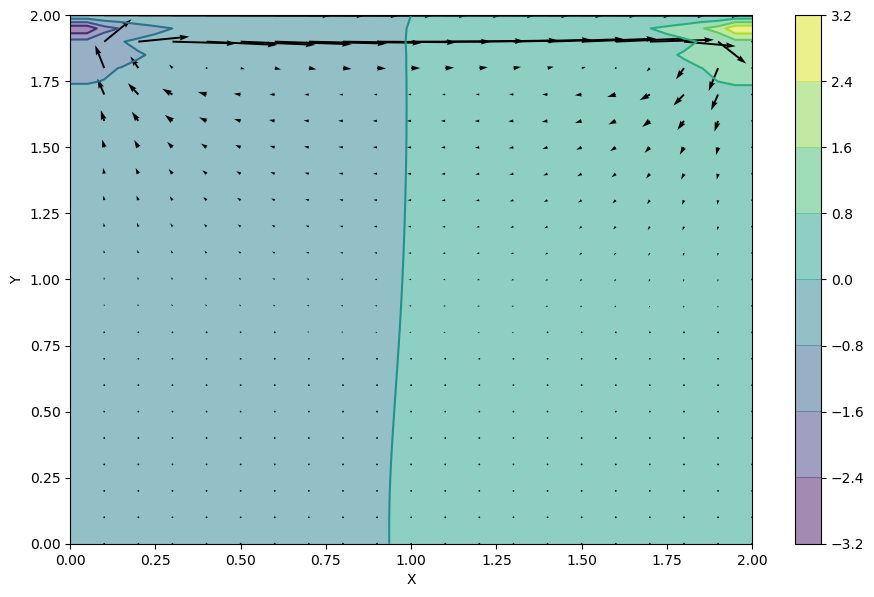

In [12]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');

You can see that two distinct pressure zones are forming and that the spiral pattern expected from lid-driven cavity flow is beginning to form.  Experiment with different values of `nt` to see how long the system takes to stabilize.  

In [13]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

p [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
p [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
p [[-3.96453208e-17 -3.96453208e-17 -3.70012254e-17 ...  3.70308382e-17
   3.96770497e-17  3.96770497e-17]
 [-3.96453208e-17 -3.96453208e-17 -3.70012254e-17 ...  3.70308382e-17
   3.96770497e-17  3.96770497e-17]
 [-2.64032970e-16 -2.64032970e-16 -2.32952608e-16 ...  2.33139045e-16
   2.64244281e-16  2.64244281e-16]
 ...
 [-2.78220334e-01 -2.78220334e-01 -1.74012335e-01 ...  1.74151601e-01
   2.78443000e-01  2.78443000e-01]
 [-4.87441649e-01 -4.87441649e-01 -1.85455253e-01 ...  1.85603677e-01
   4.87831758e-01  4.87831758e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
p [[-9.88126160e-09 -9.88126160e-09 -9.6379115

p [[-0.04771247 -0.04771247 -0.04753298 ...  0.05249707  0.052674
   0.052674  ]
 [-0.04771247 -0.04771247 -0.04753298 ...  0.05249707  0.052674
   0.052674  ]
 [-0.04802111 -0.04802111 -0.04784059 ...  0.05280914  0.05298709
   0.05298709]
 ...
 [-1.20014882 -1.20014882 -0.85448902 ...  0.85952724  1.22001003
   1.22001003]
 [-2.7889193  -2.7889193  -1.6959474  ...  1.68001256  2.79604232
   2.79604232]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
p [[-0.05230637 -0.05230637 -0.05210583 ...  0.05768546  0.05788326
   0.05788326]
 [-0.05230637 -0.05230637 -0.05210583 ...  0.05768546  0.05788326
   0.05788326]
 [-0.05259772 -0.05259772 -0.05239706 ...  0.05798043  0.05817836
   0.05817836]
 ...
 [-1.20973354 -1.20973354 -0.86199138 ...  0.86773217  1.2309161
   1.2309161 ]
 [-2.80806241 -2.80806241 -1.71331428 ...  1.69742864  2.81608673
   2.81608673]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
p [[-0.05687826 -0.05687826 -0.05

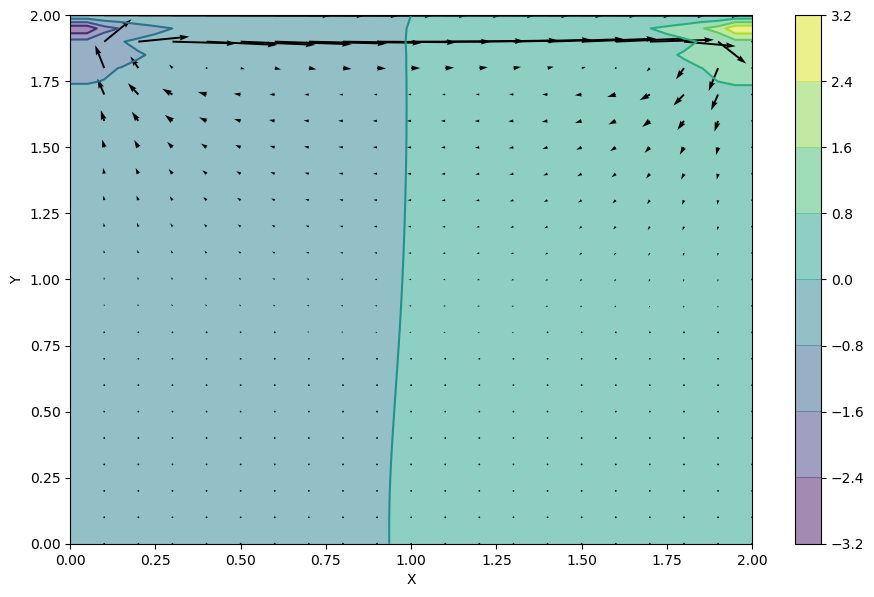

In [14]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

The quiver plot shows the magnitude of the velocity at the discrete points in the mesh grid we created.
(We're actually only showing half of the points because otherwise it's a bit of a mess.  The `X[::2, ::2]` syntax above is a convenient way to ask for every other point.)

Another way to visualize the flow in the cavity is to use a `streamplot`:

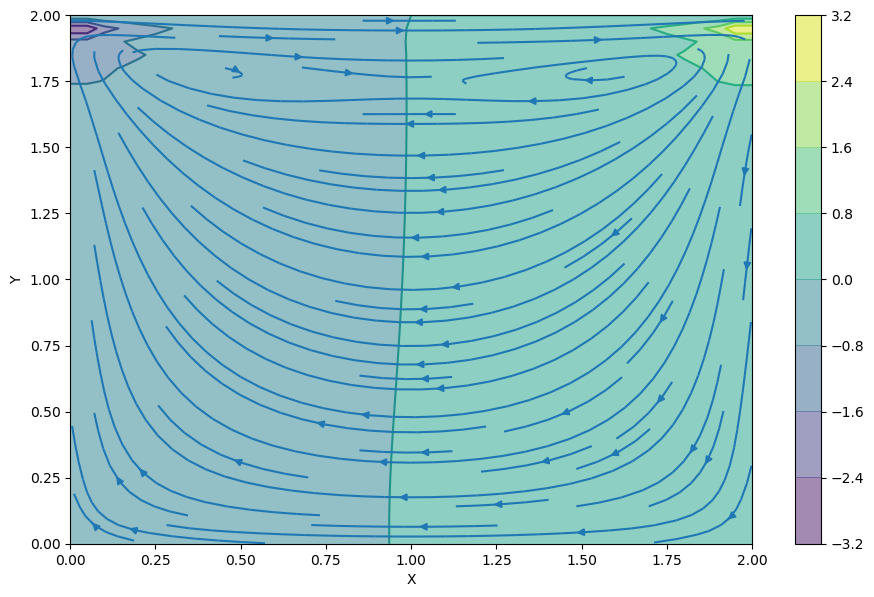

In [15]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Learn More

The interactive module **12 steps to Navier–Stokes** is one of several components of the Computational Fluid Dynamics class taught by Prof. Lorena A. Barba in Boston University between 2009 and 2013. 

For a sample of what the other components of this class are, you can explore the **Resources** section of the Spring 2013 version of [the course's Piazza site](https://piazza.com/bu/spring2013/me702/resources).

***

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: '../styles/custom.css'

> (The cell above executes the style for this notebook.)